### Projet : Enquête scientifique par analyse d’ADN
#### Objectif : Identifier les suspects dont l’ADN correspond à l’échantillon prélevé sur la scène de crime

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from difflib import SequenceMatcher
from sklearn.linear_model import LinearRegression

In [15]:
# === 1. Données brutes ===

# Séquences ADN (3 loci) de 6 suspects
data = {
    "Suspect": ["S1", "S2", "S3", "S4", "S5", "S6"],
    "Locus_1": ["ATCGTAC", "ATCCTAC", "ATCGTCC", "ATGGTAC", "AACGTAC", "ATCGTGC"],
    "Locus_2": ["GGATCTA", "GGATGGA", "GAATCGA", "GGATCGA", "GGATCCA", "GGATCGT"],
    "Locus_3": ["TTAAGC", "TTAAGT", "TTCAGC", "TTAAGC", "TTAAGG", "TTAAGC"]
}

# Échantillon retrouvé sur la scène (partiellement contaminé)
echantillon = {
    "Locus_1": "ATCGTAC",
    "Locus_2": "GGATCGA",
    "Locus_3": "TTAAGC"
}

df = pd.DataFrame(data)
df.set_index("Suspect", inplace=True)

# === 2. Fonction de comparaison ADN ===

def comparer(seq1, seq2):
    """Retourne le pourcentage de similarité entre deux séquences."""
    return round(SequenceMatcher(None, seq1, seq2).ratio() * 100, 2)

# === 3. Calcul des correspondances ===

correspondances = []

for suspect in df.index:
    matches = []
    for locus in ["Locus_1", "Locus_2", "Locus_3"]:
        score = comparer(df.loc[suspect, locus], echantillon[locus])
        matches.append(score)
    correspondances.append(matches)

cor_df = pd.DataFrame(correspondances, columns=["Locus_1", "Locus_2", "Locus_3"], index=df.index)

# Ajout d’une colonne moyenne
cor_df["Moyenne"] = cor_df.mean(axis=1)
cor_df.sort_values("Moyenne", ascending=False, inplace=True)
cor_df


,Locus_1,Locus_2,Locus_3,Moyenne
Suspect,,,,
S1,100.00,85.71,100.00,95.236667
S4,85.71,100.00,100.00,95.236667
S6,85.71,85.71,100.00,90.473333
S2,85.71,85.71,83.33,84.916667
S3,85.71,85.71,83.33,84.916667
S5,85.71,85.71,83.33,84.916667


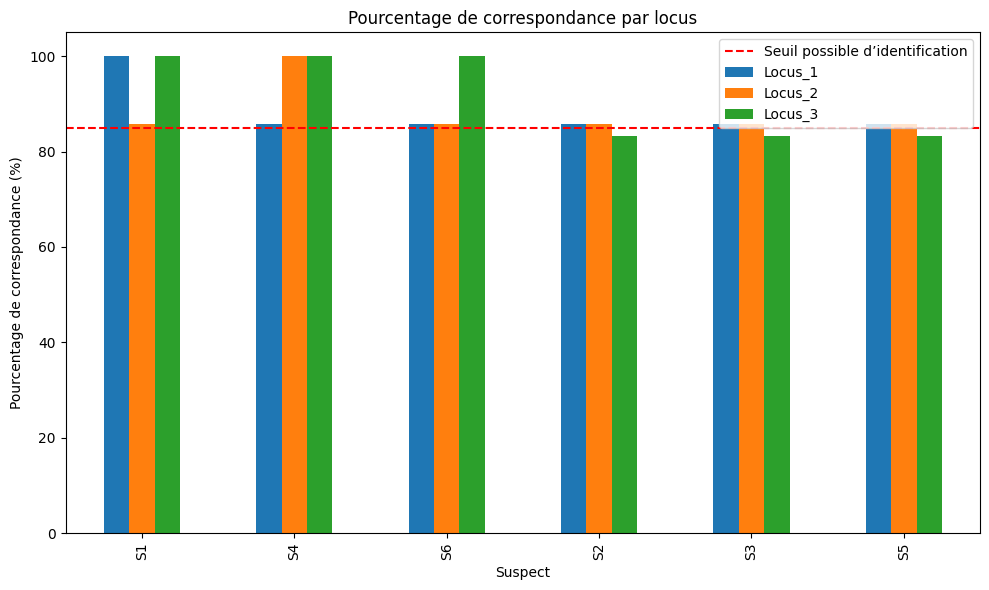

In [16]:
# === 4. Visualisation des résultats ===

cor_df[["Locus_1", "Locus_2", "Locus_3"]].plot(kind='bar', figsize=(10, 6), title="Pourcentage de correspondance par locus")
plt.axhline(85, color='red', linestyle='--', label='Seuil possible d’identification')
plt.ylabel("Pourcentage de correspondance (%)")
plt.xlabel("Suspect")
plt.legend()
plt.tight_layout()
plt.show()


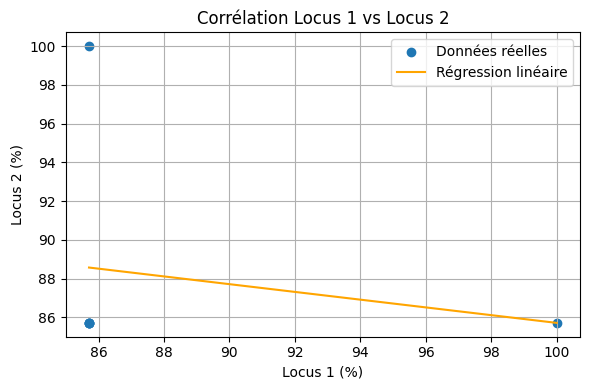

Coefficient de corrélation (R²): 0.04


In [17]:
# === 5. Analyse statistique : régression linéaire entre loci ===

# Vérifions la cohérence entre locus 1 et locus 2 par exemple

x = cor_df["Locus_1"].values.reshape(-1, 1)
y = cor_df["Locus_2"].values

modele = LinearRegression()
modele.fit(x, y)
y_pred = modele.predict(x)

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='Données réelles')
plt.plot(x, y_pred, color='orange', label='Régression linéaire')
plt.xlabel("Locus 1 (%)")
plt.ylabel("Locus 2 (%)")
plt.title("Corrélation Locus 1 vs Locus 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Coefficient de corrélation (R²):", round(modele.score(x, y), 3))


In [18]:
# === 6. Ajout d’incertitude aléatoire pour simuler du bruit biologique ===

def ajouter_bruit(seq, taux_erreur=0.1):
    """Ajoute une petite erreur aléatoire à une séquence (simulateur de contamination)"""
    bases = ['A', 'T', 'C', 'G']
    nouvelle_seq = ""
    for base in seq:
        if np.random.rand() < taux_erreur:
            nouvelle_seq += np.random.choice([b for b in bases if b != base])
        else:
            nouvelle_seq += base
    return nouvelle_seq

# Simulons un nouvel échantillon bruité
np.random.seed(42)  # Pour reproductibilité
echantillon_bruite = {k: ajouter_bruit(v, 0.1) for k, v in echantillon.items()}
print("Échantillon bruité :", echantillon_bruite)

# Recalcul des correspondances
correspondances_bruit = []

for suspect in df.index:
    matches = []
    for locus in ["Locus_1", "Locus_2", "Locus_3"]:
        score = comparer(df.loc[suspect, locus], echantillon_bruite[locus])
        matches.append(score)
    correspondances_bruit.append(matches)

cor_bruit_df = pd.DataFrame(correspondances_bruit, columns=["Locus_1", "Locus_2", "Locus_3"], index=df.index)
cor_bruit_df["Moyenne"] = cor_bruit_df.mean(axis=1)
cor_bruit_df.sort_values("Moyenne", ascending=False)


Échantillon bruité : {'Locus_1': 'ATCGTAA', 'Locus_2': 'GGCTCAA', 'Locus_3': 'TAAAGC'}


,Locus_1,Locus_2,Locus_3,Moyenne
Suspect,,,,
S1,85.71,71.43,83.33,80.156667
S4,71.43,71.43,83.33,75.396667
S6,71.43,57.14,83.33,70.633333
S5,71.43,71.43,66.67,69.843333
S2,71.43,57.14,66.67,65.080000
S3,71.43,42.86,66.67,60.320000


In [19]:
# === 7. Conclusion automatique ===

meilleur_suspect = cor_df["Moyenne"].idxmax()
score = cor_df["Moyenne"].max()

if score > 85:
    print(f"🔍 Le suspect le plus probable est {meilleur_suspect}, avec une correspondance moyenne de {score:.2f}%.")
else:
    print("❗Aucun suspect ne correspond suffisamment pour être identifié avec confiance.")


🔍 Le suspect le plus probable est S1, avec une correspondance moyenne de 95.24%.
